In [1]:
from numpy import array as ar
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm

In [2]:
def objective(x, noise = 0.1):
	noise = np.random.normal(loc=0, scale = noise)
	multimodal = (x**2 * np.sin(5*np.pi*x)**6) + noise
	return multimodal

In [3]:
# The grid-base:
hyperparameter_inferior_limit = 0
hyperparameter_superior_limit = 1
step = 0.01

In [4]:
X = np.arange(hyperparameter_inferior_limit,hyperparameter_superior_limit,step)
multimodal = objective(X)

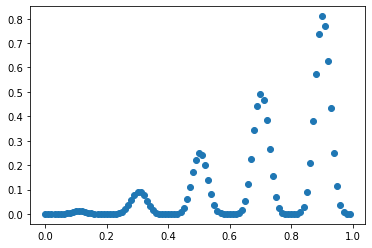

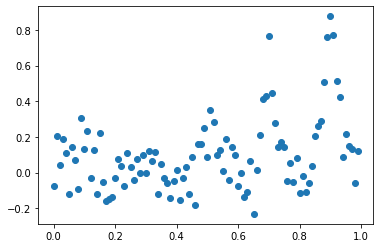

In [5]:
def plot_one(X,multimodal):
	plt.scatter(x = X, y = multimodal)
	plt.show()
# evaluate without noise
y = [objective(x,0) for x in X]
y_noise = [objective(x) for x in X]
plot_one(X,y)
plot_one(X,y_noise)

In [6]:
argument_index_maximizes_function = np.argmax(y)
idx = argument_index_maximizes_function
print(f'Optima value is (X = {X[idx]},y = {y[idx]})')

Optima value is (X = 0.9,y = 0.81)


In [7]:
#surrogate or approximation for the objective function
# since we do not have its shape, we will use some way to find the intermediate points
# Gaussian Process Regressor
model = GaussianProcessRegressor()
X = X.reshape(-1,1)
# fit the model
model.fit(X, y)
def surrogate(model, X):
	return model.predict(X, return_std=True)

#nao eh yhat probabilidade, eh yhat valor? valor mesmo, regressao, qual valor provavel, o valor e seu desvio padrao sao retornados
y_hat = surrogate(model, X)

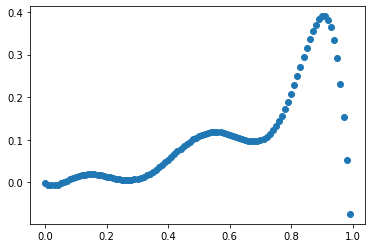

In [8]:
# tem um desvio padrao nessa curva que nao estou plotando
# X dominio
# y valor predito pelo GaussianProcessRegressor
plt.scatter(x = X, y = y_hat[0]);

In [9]:
def plot(X, y, model):
    '''
    X: real values of hyperparameters which were already tested
    y: real objective values (already evaluated)
    model: gaussian model, which was fitted using the X and y values
    
    >> From this model we will have an estimation of the function (which we do not know their format, NEVER KNOW !!!!)

    > Scatter points are from real values
    > Line belongs to predicted surrogate model, which is only an estimate of how the function works
    '''
    
    # scatter plot of inputs and real objective function
    plt.scatter(X, y)

    # line plot of surrogate function across domain
    Xsamples = np.asarray(np.arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    plt.plot(Xsamples, ysamples)
    # show the plot
    plt.show()

In [10]:
# Amostrar do dominio esparso com disturbio
# a nao didatica aqui eh que o dominio vai de 0 ate 1, por isso o default dessa querida funcao da certo
X = np.random.random(100)

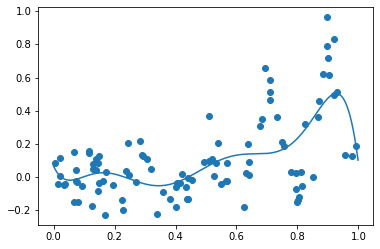

In [11]:
# line is the real function (which generally we do not know, actually, WE NEVER KNOW !!!!!!!)
# points are the estimates of the surrogate_function with the grid passed, the grid was a random sample between 0 and 1 

# Para valores aleatorios entre 0 e 1, rode a objective function, nao a surrogate, e plote o resultado
y = np.asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot the surrogate function
plot(X, y, model)

In [12]:
# otimizar a funcao de aquisicao
def otimizar_funcao_aquisicao(X, y, model):
	# random search, gerar amostras aleatórias
	# no optuna essa distribuicao já não está disponível do range que passamos?
    
    #TODO
    # teria que parametrizar isso aqui, alias melhor utilizar random.uniform
    # o dominio dessa porcaria eh entre 0 e 1 
	Xsamples = np.random.random(100)

	Xsamples = Xsamples.reshape(len(Xsamples), 1)

	# Calcular a funcao de aquisicao 
    # aqui podem retornar varios
    # mas la em baixo soh pegamos o argmax
	scores = funcao_aquisicao(X, Xsamples, model)

	# localizar o indice com maior socre da funcao de aquisicao
    # ou seja, qual o proximo queridinho que vale a pena jogarmos no modelo pra ver se presta, e retornar outro
    # valor na objective_function
	idx = np.argmax(scores)

	# Retorne a partir da amostra aleatória, qual dos valores que maximiza a funcao de aquisicao
    # justamente aqui, o valor do queridinho
	return Xsamples[idx, 0]

In [13]:
def funcao_aquisicao(X, Xsamples, model):
    '''
    X - grid do espaco que ja foi rodado a surrogate function?
    Xsamples - novas samples que podemos ver qual sera o resultado da model?
    model -  o modelo que foi fitado com o grid existente, com valores que já existem de parametros testados, 
    e o valor final da surrogate function (average_precision, por exemplo?)
    '''
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs

In [14]:
X_aleatorio = np.random.random(100)

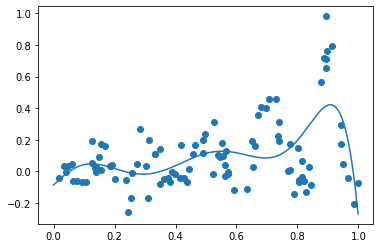

In [15]:
y = np.asarray([objective(x) for x in X_aleatorio])
# reshape into rows and cols
X = X_aleatorio.reshape(len(X_aleatorio), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)

In [16]:
yhat, _ = surrogate(model, X)

In [17]:
media, desvio_padrao = surrogate(model, X)

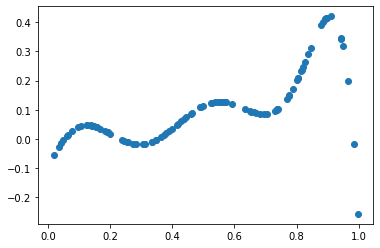

In [18]:
plt.scatter(x = X, y = media)

In [19]:
maior_valor_estimado_surrogate = max(yhat)

In [20]:
# sabemos que na funcao objetivo mesmo, o valor é superior
print(maior_valor_estimado_surrogate)

0.42084789276123047


In [21]:
argmax_surrogate = np.argmax(yhat)

In [22]:
print(X[argmax_surrogate])

[0.91216127]


In [23]:
# Se formos olhar lah em cima, o maior valor da funcao objetivo foi de 0.81 e o valor que maximizava isso era o de 0.91, entao estamos bem proximos

In [24]:
# media eh o valor predito pela GaussianRegressor
# nome ruim
media_menos_maior_valor = (media - maior_valor_estimado_surrogate)
valores_normalizados = media_menos_maior_valor/(desvio_padrao)

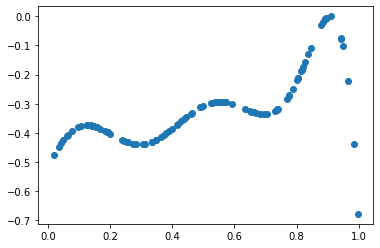

In [25]:
plt.scatter(x = X, y = media_menos_maior_valor)

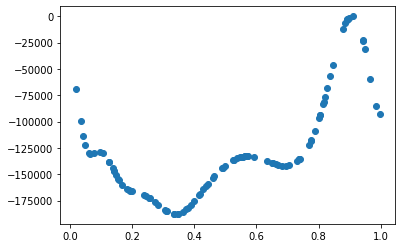

In [26]:
# negativo para todos, menos o maior valor
# MAS CALMAAA, AQUI PODE RETORNAR MAIS DE UM VALOR QUE SERA MAIOR QUE ZERO, DADO QUE TEMOS O DESVIO PADRAO DE CADA PONTO DA
# PREDICAO DO GAUSSIANPROCESSREGRESSOR()
plt.scatter(x = X, y = valores_normalizados)

In [27]:
print(type(valores_normalizados))

<class 'numpy.ndarray'>


In [28]:
# quando fazemos a acumulada pegamos quais sao menores que zero e quais sao maiores?
# mas precisa da acumulada pra isso?
acumulada = norm.cdf(x = valores_normalizados)

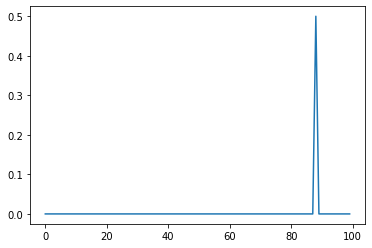

In [29]:
plt.plot(acumulada)

In [30]:
probs = norm.cdf(x = valores_normalizados)

In [31]:
probs

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

# opt

In [32]:
# Entao com X ja temos os valores, ate o momento, no optuna, avaliados quanto a performance

print(X)

In [33]:
# Com y ja temos quao bem eles foram 

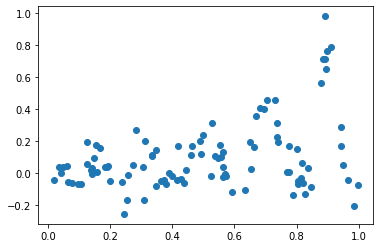

In [34]:
plt.scatter(x = X, y = y)

- agora vamos realizar a otimizacao, para saber qual valor, dentre todos estes ja avaliados, 
vale a pena seguir pra testar e adicionar no array de ja testados e valor ja avaliado pela objective_function

In [223]:
N_TRIALS = 50

In [224]:
# vamos super que as duas primeiras vezes que rodei o optuna, vai dar determinado resultado
INITIAL_SIZE = 2

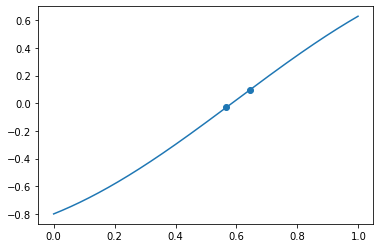

In [225]:
# sample the domain sparsely with noise
X = np.random.random(INITIAL_SIZE)
y = np.asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)

In [226]:
TRIALS_AFTER_FIRST_ONES = N_TRIALS - INITIAL_SIZE
# perform the optimization process
xs = []
actuals = []
estimativas = []
for i in range(TRIALS_AFTER_FIRST_ONES):
    # select the next point to sample
    x = otimizar_funcao_aquisicao(X, y, model)
    xs.append(x)
    print(f'\n\nProximo queridinho que vale a pena testar: {x}')
    
    # sample the point
    
    actual = objective(x)
    actuals.append(actual)
    print(f'\nTestando o queridinho {x} no optuna o resultado foi de {actual}')
    
    # summarize the finding
    estimativa_queridinho, _ = surrogate(model, [[x]])
    estimativas.append(estimativa_queridinho[0])
    
    print(f'\nA partir de x={x} a funcao objetivo retornou y_real={actual} e a surrogate_function retornou yhat = {estimativa_queridinho[0]}')
          
    # adiciona o novo queridinho que testamos ao dataset de tentativas e respostas, para conseguirmos continuar na otimizacao
          
    # add the data to the dataset
    X = np.vstack((X, [[x]]))
    y = np.vstack((y, [[actual]]))
    # update the model
    model.fit(X, y)



Proximo queridinho que vale a pena testar: 0.7651007513879955

Testando o queridinho 0.7651007513879955 no optuna o resultado foi de 0.0446074139752881

A partir de x=0.7651007513879955 a funcao objetivo retornou y_real=0.0446074139752881 e a surrogate_function retornou yhat = 0.29220190725558837


Proximo queridinho que vale a pena testar: 0.7135488718411347

Testando o queridinho 0.7135488718411347 no optuna o resultado foi de 0.459484444540781

A partir de x=0.7135488718411347 a funcao objetivo retornou y_real=0.459484444540781 e a surrogate_function retornou yhat = 0.10406466086988075


Proximo queridinho que vale a pena testar: 0.016966174992990135

Testando o queridinho 0.016966174992990135 no optuna o resultado foi de 0.10586426773372234

A partir de x=0.016966174992990135 a funcao objetivo retornou y_real=0.10586426773372234 e a surrogate_function retornou yhat = 135.12642976175994


Proximo queridinho que vale a pena testar: 0.5036055165402596

Testando o queridinho 0.503605

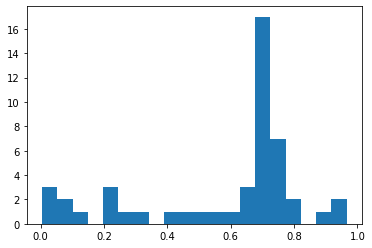

In [227]:
# deve ter maior concentracao de x onde a funcao objetivo é maior, ou seja, proximo de 0.9
plt.hist(xs, bins = 20);

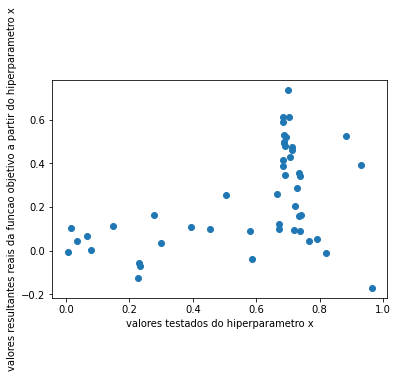

In [228]:
# o comportamento da funcao objetivo esta fazendo sentido
plt.scatter(x = xs, y = actuals)
plt.xlabel('valores testados do hiperparametro x')
plt.ylabel('valores resultantes reais da funcao objetivo a partir do hiperparametro x')
plt.show()

In [229]:
pair_values = np.array(pair_values)

In [230]:
_xs = pair_values[:,0]

In [231]:
_ests = pair_values[:,1]

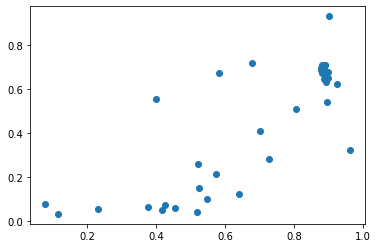

In [232]:
# porque as estimativas da surrogate function, possuem um formato parecido com os valores obtidos da objective function real, 
# a otimizacao deve funcionar\
plt.scatter(x = _xs, y = _ests)

In [233]:
model = GaussianProcessRegressor()

In [234]:
model.fit(X = np.array(xs).reshape(-1,1), y = np.array(actuals))

GaussianProcessRegressor()

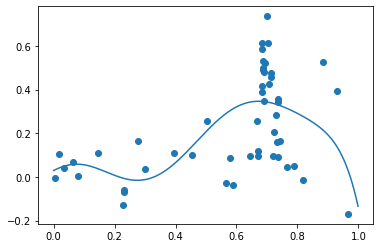

In [235]:
plot(X, y, model)